<a href="https://www.kaggle.com/code/mahsazamanifard/analyzing-consumer-behavior-using-cohort-analysis?scriptVersionId=106002012" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<span style='color:orange; font-size:20px;'><i>In this notebook we're going to try and answer 3 questions using the dataset and cohort analysis
the questios are:</i></span>

<a id="sections"></a>
- [<span style='color:orange; font-size:16px;'><i>Q1: According to the dataset, how many orders are likely to be placed in August from customers who joined in July?</i></span>](#1)
 - [<span style='color:orange; font-size:14px;'><i>Q1 Answer</i></span>](#1.1)

- [<span style='color:orange; font-size:16px;'><i>Q2: What is the effect of discount on the first purchase, on customer behavior in the future?</i></span>](#2)
 - [<span style='color:orange; font-size:14px;'><i>Q2 Answer</i></span>](#2.1)

- [<span style='color:orange; font-size:16px;'><i>Q3: How long is the time between the first and second, second and third and so on, orders?</i></span>](#3)
 - [<span style='color:orange; font-size:14px;'><i>Q3 Answer</i></span>](#3.1)

# Import and Clean

In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns

/kaggle/input/mytask/Data analyst Task.csv


In [2]:
snapp=pd.read_csv("/kaggle/input/mytask/Data analyst Task.csv") 

In [3]:
data=snapp.copy()

In [4]:
data.shape

(29057, 6)

In [5]:
data.head(10)

,order_id,user_id,created_at,discount_cost,discount_type,basket
0,1,1,4/12/2021,10000,1.0,12000
1,2,2,5/9/2021,0,NaN,20000
2,3,3,5/9/2021,10000,1.0,14000
3,4,4,11/10/2021,0,NaN,15000
4,5,5,11/10/2021,10000,1.0,16000
5,6,6,1/1/2022,0,NaN,10000
6,7,7,1/1/2022,0,NaN,29500
7,8,8,1/1/2022,10000,1.0,10000
8,9,9,1/1/2022,0,NaN,5000
9,10,10,1/1/2022,0,NaN,35000


In [6]:
data.discount_type.unique()

array([ 1., nan,  2.])

In [7]:
data.discount_type[data.discount_cost==0].isna().all()
#this shows that through the whole dataset, where there's no discount, discount_type value is Nan
#So I'll replace all the Nan values in this column with 0, discount_type=0 means no discount.

True

In [8]:
data.discount_type.fillna(0,inplace=True)

In [9]:
data.isna().sum()

order_id         0
user_id          0
created_at       0
discount_cost    0
discount_type    0
basket           0
dtype: int64

In [10]:
data.created_at.value_counts() #format of date is American, MM/DD/YYYY

7/1/2022      304
7/15/2022     275
7/22/2022     271
6/17/2022     255
6/24/2022     249
             ... 
1/2/2022       36
4/2/2022       32
5/9/2021        2
11/10/2021      2
4/12/2021       1
Name: created_at, Length: 215, dtype: int64

In [11]:
data['created_at'] = pd.to_datetime(data['created_at']) #I'll cast the data type to datetime for easier processing

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29057 entries, 0 to 29056
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       29057 non-null  int64         
 1   user_id        29057 non-null  int64         
 2   created_at     29057 non-null  datetime64[ns]
 3   discount_cost  29057 non-null  int64         
 4   discount_type  29057 non-null  float64       
 5   basket         29057 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 1.3 MB


In [13]:
data.user_id.nunique() #there are 9985 unique users

9985

In [14]:
#a function to return the month and year
def get_month(x): return dt.datetime(x.year, x.month, 1) 

In [15]:
#since datetime can't directy be applied to a series, we need to use apply
data['purchase_month'] = data['created_at'].apply(get_month)

In [16]:
data.head(10)

,order_id,user_id,created_at,discount_cost,discount_type,basket,purchase_month
0,1,1,2021-04-12,10000,1.0,12000,2021-04-01
1,2,2,2021-05-09,0,0.0,20000,2021-05-01
2,3,3,2021-05-09,10000,1.0,14000,2021-05-01
3,4,4,2021-11-10,0,0.0,15000,2021-11-01
4,5,5,2021-11-10,10000,1.0,16000,2021-11-01
5,6,6,2022-01-01,0,0.0,10000,2022-01-01
6,7,7,2022-01-01,0,0.0,29500,2022-01-01
7,8,8,2022-01-01,10000,1.0,10000,2022-01-01
8,9,9,2022-01-01,0,0.0,5000,2022-01-01
9,10,10,2022-01-01,0,0.0,35000,2022-01-01


# <a id='1'>  Q1: According to the dataset, how many orders are likely to be placed in August from customers who joined in July?</a>

Here are the steps we can take:

1) calculate the retention rate in the previous months, then calculate the mean retention rate, this way we'll have an estimate of the number of users who joined on July and are going to be active on August

2) find on average how many orders are placed in the second month for each cohort and multiply it by the number of users which gives us the approximate number of orders placed in August, by users joined on July

[List of Content](#sections)

In [17]:
#adding a column that indicates the first purchase month for each user
data['first_purchase']=data.groupby('user_id')['purchase_month'].transform('min')

In [18]:
#testing to see if it worked properly
data[data.user_id==3]

,order_id,user_id,created_at,discount_cost,discount_type,basket,purchase_month,first_purchase
2,3,3,2021-05-09,10000,1.0,14000,2021-05-01,2021-05-01
7712,7713,3,2022-03-28,0,0.0,18000,2022-03-01,2021-05-01
26085,26086,3,2022-07-17,0,0.0,18000,2022-07-01,2021-05-01
26302,26303,3,2022-07-18,0,0.0,13500,2022-07-01,2021-05-01


In [19]:
#this indicates the nth month of joining/starting to purchase, we start with 1 for convenience
data['cohort_period']=12*((data['purchase_month'].dt.year)-(data['first_purchase'].dt.year))+((data['purchase_month'].dt.month)-(data['first_purchase'].dt.month))

In [20]:
#testing to see if it worked properly
data[data.user_id==3]

,order_id,user_id,created_at,discount_cost,discount_type,basket,purchase_month,first_purchase,cohort_period
2,3,3,2021-05-09,10000,1.0,14000,2021-05-01,2021-05-01,0
7712,7713,3,2022-03-28,0,0.0,18000,2022-03-01,2021-05-01,10
26085,26086,3,2022-07-17,0,0.0,18000,2022-07-01,2021-05-01,14
26302,26303,3,2022-07-18,0,0.0,13500,2022-07-01,2021-05-01,14


In [21]:
# we want to see how many UNIQUE users were active in each cohort, based on their first purchase and the cohort period
# This is going to come in handy when creating a heatmap for different cohorts
users_per_month=data.groupby(['first_purchase', 'cohort_period'])['user_id'].nunique().reset_index()
users_per_month.head(15)

,first_purchase,cohort_period,user_id
0,2021-04-01,0,1
1,2021-04-01,11,1
2,2021-04-01,13,1
3,2021-05-01,0,2
4,2021-05-01,10,1
5,2021-05-01,13,1
6,2021-05-01,14,1
7,2021-11-01,0,2
8,2021-11-01,2,1
9,2021-11-01,4,1


In [22]:
# Now we should create a pivot table to make creating a heatmap easier
retention = users_per_month.pivot(index='first_purchase',
                                 columns ='cohort_period',
                                 values = 'user_id')
retention

cohort_period,0,1,2,3,4,5,6,10,11,13,14
first_purchase,,,,,,,,,,,
2021-04-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN
2021-05-01,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0
2021-11-01,2.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2022-01-01,1491.0,457.0,365.0,378.0,316.0,317.0,324.0,NaN,NaN,NaN,NaN
2022-02-01,1539.0,385.0,393.0,362.0,354.0,337.0,NaN,NaN,NaN,NaN,NaN
2022-03-01,1255.0,305.0,274.0,259.0,276.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-01,1592.0,421.0,389.0,391.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-01,1192.0,352.0,287.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-01,1396.0,405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
#now we need to calculate the retention rate
retention_prcnt = retention.divide(retention[0], axis=0)
retention_prcnt.round(3)*100

cohort_period,0,1,2,3,4,5,6,10,11,13,14
first_purchase,,,,,,,,,,,
2021-04-01,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,NaN
2021-05-01,100.0,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,50.0,50.0
2021-11-01,100.0,NaN,50.0,NaN,50.0,50.0,NaN,NaN,NaN,NaN,NaN
2022-01-01,100.0,30.7,24.5,25.4,21.2,21.3,21.7,NaN,NaN,NaN,NaN
2022-02-01,100.0,25.0,25.5,23.5,23.0,21.9,NaN,NaN,NaN,NaN,NaN
2022-03-01,100.0,24.3,21.8,20.6,22.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-01,100.0,26.4,24.4,24.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-01,100.0,29.5,24.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-01,100.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
retention_prcnt.index=retention_prcnt.index.strftime('%Y-%m')

Text(66.5, 0.5, 'First Purchase Date')

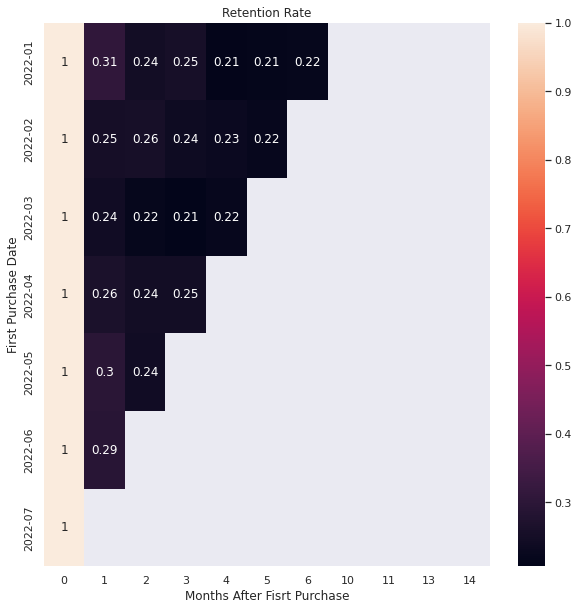

In [25]:
g=sns.set(rc={'figure.figsize':(10,10)})
g=sns.heatmap(data=retention_prcnt.iloc[3:,:],annot=True)
g.set_title('Retention Rate')
g.set_xlabel('Months After Fisrt Purchase')
g.set_ylabel('First Purchase Date')

In [26]:
mean_retention_percentage=retention_prcnt[1].mean()

In [27]:
first_prch_July=retention.loc['2022-07-01',0]*mean_retention_percentage

In [28]:
first_prch_July #so around 417 customers who first purchased in July, are going to purchase something in August

416.51387354993096

So we probably will have around 417 users in August who had their first purchase in July.
We want the number of purchases in August, so we need to know on average, how many purchases are made in the second month, by people who purchased something for the first time in the previous month.

In [29]:
#this data is heavily skewed so we calculate the median instead of the mean
data[data.cohort_period==2].groupby(['user_id']).size().median()

1.0

## <a id='1.1'>Q1 Answer: </a>
So probably around 417 purchases will be made in August

[List of Content](#sections)

# <a id='2'> Q2: What is the effect of discount on the first purchase, on customer behavior in the future?</a>

What we'll do for this section is:

1.  divide users into 3 groups based on the discount they received on their first purchase
1.  calculate retention rate for each group and see how first purchase discount affects user retention
1.  calculate CLV (Customer Lifetime Value) using below formula:

## **A little bit about CLV:**

**Definition of CLV:** Customer lifetime value (CLV) is a measure of the total income a business can expect to bring in from a typical customer for as long as that person or account remains a client.

**How to calculate CLV?**
there are different ways we can caclulate it, in this [medium](https://medium.com/swlh/5-simple-ways-to-calculate-customer-lifetime-value-5f49b1a12723) post, we can read about 5 ways of calculating CLV.

For this problem, I'm going to take a simple approach, I'll calculate the average of each customer spending during the time between the first and the last purchase, in each group of discounts.

[List of Content](#sections)

In [30]:
data[data.discount_type!=0].cohort_period.value_counts(normalize=True)
#discounts are not just for first time purchasers, but here we want to examine the effect of
#discounts on the first purchasers

0    0.697329
1    0.113069
2    0.077545
3    0.045632
4    0.031769
5    0.023249
6    0.011408
Name: cohort_period, dtype: float64

In [31]:
data.discount_type.value_counts(normalize=True)

0.0    0.761675
1.0    0.233575
2.0    0.004749
Name: discount_type, dtype: float64

In [32]:
data.groupby('discount_type')['discount_cost'].mean()

discount_type
0.0        0.000000
1.0    10595.093561
2.0     5749.565217
Name: discount_cost, dtype: float64

In [33]:
first_prch=data.groupby('user_id')['order_id'].min() #finding the smallest order_id, which would be the first purchase

In [34]:
first_prch

user_id
1           1
2           2
3           3
4           4
5           5
        ...  
9981    29031
9982    29034
9983    29036
9984    29039
9985    29054
Name: order_id, Length: 9985, dtype: int64

### **CLV for the discount 0 group**

In [35]:
#unique user ids with discount type 0 in their first purchase
disc0=data.user_id[(data.discount_type==0)&(data.order_id.isin(first_prch))].unique()

In [36]:
#sum of purchase value for each customer
gp0_purchase_size=data[data.user_id.isin(disc0)].groupby('user_id')['basket'].sum()

In [37]:
#sum maximum of cohort period which is the time each customer has been active
gp0_life_time=data[data.user_id.isin(disc0)].groupby('user_id')['cohort_period'].max()

In [38]:
#+1 so that users with cohort_period of 0 won't cause problems
gp0_life_time_value=gp0_purchase_size/(gp0_life_time+1)

In [39]:
#We'll focus on the median because data is skewed
display(gp0_life_time_value.median(),gp0_life_time_value.mean())

24000.0

34653.14159889882

So customers in the discount group 0, would on average spend 24000, during the time they are active

### **CLV for the discount 1 group**

In [40]:
#unique user ids with discount type 1 in their first purchase
disc1=data.user_id[(data.discount_type==1)&(data.order_id.isin(first_prch))].unique()

In [41]:
gp1_purchase_size=data[data.user_id.isin(disc1)].groupby('user_id')['basket'].sum()

In [42]:
gp1_life_time=data[data.user_id.isin(disc1)].groupby('user_id')['cohort_period'].max()

In [43]:
#+1 so that users with cohort_period of 0 won't cause problems
gp1_life_time_value=gp1_purchase_size/(gp1_life_time+1)

In [44]:
#We'll focus on the median because data is skewed
display(gp1_life_time_value.median(),gp1_life_time_value.mean())

19000.0

24691.793104306285

So customers in the discount group 1, would on average spend 19000, during the time they are active

### **CLV for the discount 2 group**

In [45]:
#unique user ids with discount type 2 in their first purchase
disc2=data.user_id[(data.discount_type==2)&(data.order_id.isin(first_prch))].unique()

In [46]:
gp2_purchase_size=data[data.user_id.isin(disc2)].groupby('user_id')['basket'].sum()

In [47]:
gp2_life_time=data[data.user_id.isin(disc2)].groupby('user_id')['cohort_period'].max()

In [48]:
#+1 so that users with cohort_period of 0 won't cause problems
gp2_life_time_value=gp2_purchase_size/(gp2_life_time+1)

In [49]:
#We'll focus on the median because data is skewed
display(gp2_life_time_value.median(),gp2_life_time_value.mean())

27500.0

34469.76190476191

So customers in the discount group 2, would on average spend 27500, during the time they are active, but it's notable that we don't have that many users who got discount type 2 on their first purchase

## <a id='2.1'>Q2 Answer</a>

[List of Content](#sections)

Text(0.5, 1.0, 'Customer Lifetime Value')

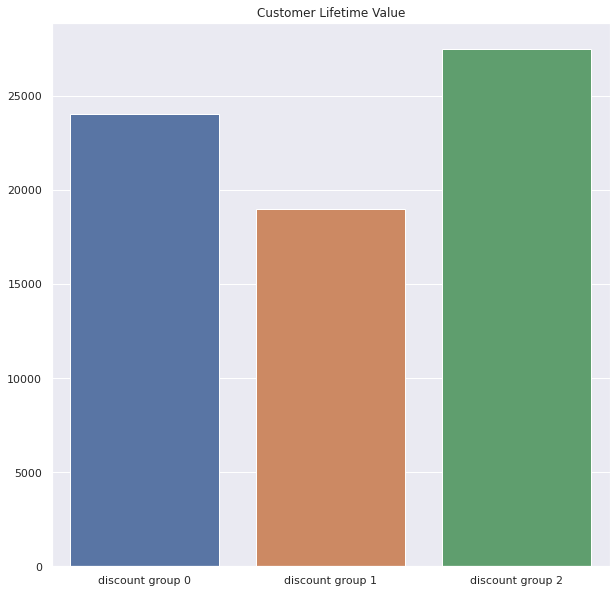

In [50]:
g=sns.barplot(y=[gp0_life_time_value.median(),gp1_life_time_value.median(),gp2_life_time_value.median()],x=['discount group 0','discount group 1','discount group 2'])
g.set_title('Customer Lifetime Value')

As it's evident, people in discount group 1, purchase the least, during their active time of purchasing.
discount group 0 comes second and discount group 2 comes first.

## Retention Rate For Each Discount Group:
We can also calculate the retention rate to examine the effect of first purchase discount on retention rate

In [51]:
def retention_rate(df):
    users_per_month=df.groupby(['first_purchase', 'cohort_period'])['user_id'].nunique().reset_index()
    retention = users_per_month.pivot(index='first_purchase',
                                 columns ='cohort_period',
                                 values = 'user_id')
    retention_prcnt = retention.divide(retention[0], axis=0)
    retention_prcnt.index=retention_prcnt.index.strftime('%Y-%m')
    g=sns.set(rc={'figure.figsize':(10,10)})
    g=sns.heatmap(data=retention_prcnt,annot=True,cmap='Pastel1')
    g.set_title('Retention Rate')
    g.set_xlabel('Months After Fisrt Purchase')
    g.set_ylabel('First Purchase Date')
    return g

<AxesSubplot:title={'center':'Retention Rate'}, xlabel='Months After Fisrt Purchase', ylabel='First Purchase Date'>

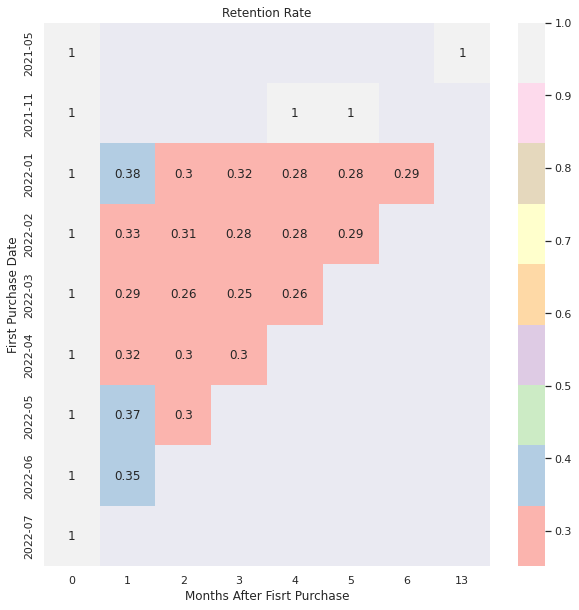

In [52]:
#discount type 0 for the first purchase retention rate
retention_rate(data[data['user_id'].isin(disc0)])

<AxesSubplot:title={'center':'Retention Rate'}, xlabel='Months After Fisrt Purchase', ylabel='First Purchase Date'>

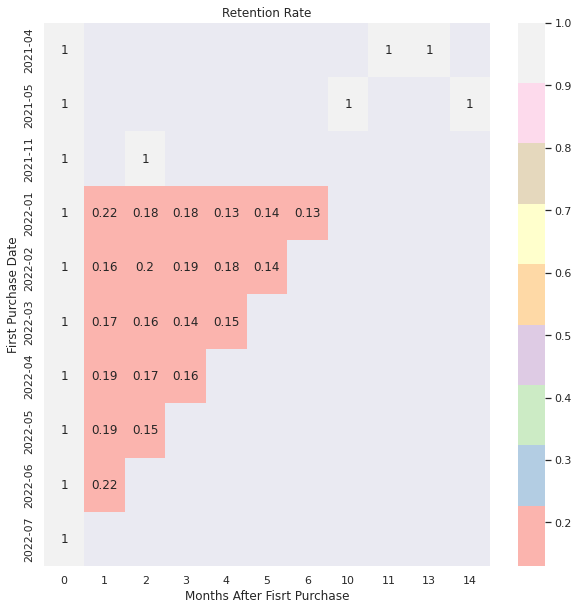

In [53]:
#discount type 1 for the first purchase retention rate
retention_rate(data[data['user_id'].isin(disc1)])

<AxesSubplot:title={'center':'Retention Rate'}, xlabel='Months After Fisrt Purchase', ylabel='First Purchase Date'>

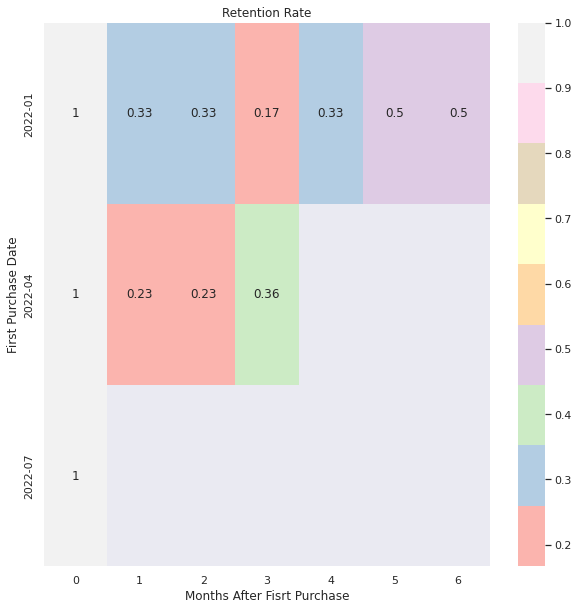

In [54]:
#discount type 2 for the first purchase retention rate
retention_rate(data[data['user_id'].isin(disc2)])

As we can see, the discount 0 group experiences less retention drop than discount 1 group, but discount 2 group has experienced some increase in the retained users actually.

# <a id='3'>Q3: How are the first to second, second to third, so on, orders spaced?</a>

Here are the steps we're going to take:

1. Finding users with more than 1 purchase

1. Sorting the dataset accroding to user_id and cohort_period

1. Finding the time between each purchase to the next one for each user
1. Create a pivot table with the intervals (from first to second, second to third , so on) as columns and user_ids as rows
1. Finding the median value of each column (since columns are heavily skewed), this lets us know on average how long after each purchase, the users makes another purchase)

[List of Content](#sections)

<AxesSubplot:>

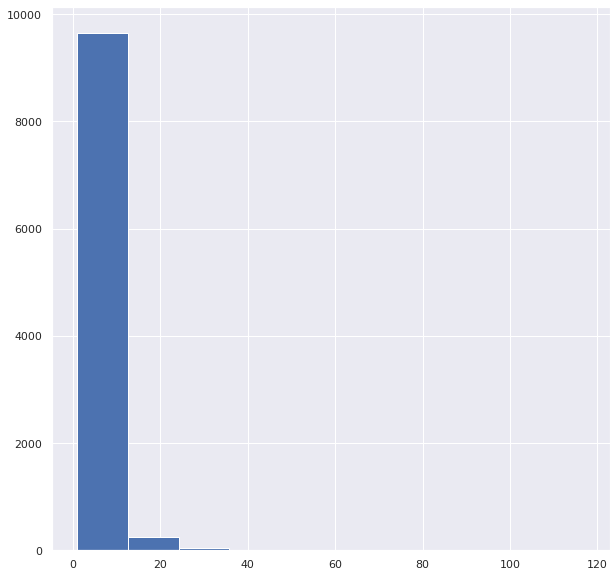

In [55]:
data.user_id.value_counts().hist()

In [56]:
data.user_id.value_counts()[data.user_id.value_counts()==1].shape #5541 out of 9985 users have purchase only once

(5541,)

In [57]:
multi_purchase=data.user_id.value_counts()[data.user_id.value_counts()>1] #4444 out of 9985 users have a second or more purchase

In [58]:
np.percentile(data.user_id.value_counts(),95) #95% of the users have purchased something 10 or less times

10.0

In [59]:
multi_data=data[data.user_id.isin(multi_purchase.index)] #filtering out the users with more than once purchase histor

In [60]:
multi_data=multi_data.sort_values(['user_id','cohort_period']) #sorting the data according to user_id and cohort_period so we can calculate intervals for each user easily

In [61]:
multi_data.head(20)

,order_id,user_id,created_at,discount_cost,discount_type,basket,purchase_month,first_purchase,cohort_period
0,1,1,2021-04-12,10000,1.0,12000,2021-04-01,2021-04-01,0
7703,7704,1,2022-03-28,0,0.0,6400,2022-03-01,2021-04-01,11
7980,7981,1,2022-03-31,0,0.0,5000,2022-03-01,2021-04-01,11
13984,13985,1,2022-05-09,0,0.0,6800,2022-05-01,2021-04-01,13
1,2,2,2021-05-09,0,0.0,20000,2021-05-01,2021-05-01,0
17778,17779,2,2022-06-04,0,0.0,41000,2022-06-01,2021-05-01,13
2,3,3,2021-05-09,10000,1.0,14000,2021-05-01,2021-05-01,0
7712,7713,3,2022-03-28,0,0.0,18000,2022-03-01,2021-05-01,10
26085,26086,3,2022-07-17,0,0.0,18000,2022-07-01,2021-05-01,14
26302,26303,3,2022-07-18,0,0.0,13500,2022-07-01,2021-05-01,14


In [62]:
multi_data_shift=multi_data.groupby('user_id').apply(lambda multi_data:(multi_data.created_at-multi_data.created_at.shift(1)).dt.days).reset_index() #calculating intervals between purchases for each group (each user)

In [63]:
multi_data_shift

,user_id,level_1,created_at
0,1,0,NaN
1,1,7703,350.0
2,1,7980,3.0
3,1,13984,39.0
4,2,1,NaN
...,...,...,...
23511,9915,28684,NaN
23512,9915,28842,0.0
23513,9915,28894,1.0
23514,9940,28831,NaN


In [64]:
multi_data_shift=multi_data_shift.rename(columns={'created_at':'interval'})

In [65]:
multi_data_shift.index=multi_data_shift.level_1

In [66]:
multi_data_shift.drop(columns='level_1',inplace=True)

In [67]:
multi_data_shift #after some adjusting, we have the intervals and indexes ready to join the main dataset for multiple purchase users

,user_id,interval
level_1,,
0,1,NaN
7703,1,350.0
7980,1,3.0
13984,1,39.0
1,2,NaN
...,...,...
28684,9915,NaN
28842,9915,0.0
28894,9915,1.0


In [68]:
multi_data=multi_data.join(multi_data_shift.interval)

In [69]:
multi_data.head(10)

,order_id,user_id,created_at,discount_cost,discount_type,basket,purchase_month,first_purchase,cohort_period,interval
0,1,1,2021-04-12,10000,1.0,12000,2021-04-01,2021-04-01,0,NaN
7703,7704,1,2022-03-28,0,0.0,6400,2022-03-01,2021-04-01,11,350.0
7980,7981,1,2022-03-31,0,0.0,5000,2022-03-01,2021-04-01,11,3.0
13984,13985,1,2022-05-09,0,0.0,6800,2022-05-01,2021-04-01,13,39.0
1,2,2,2021-05-09,0,0.0,20000,2021-05-01,2021-05-01,0,NaN
17778,17779,2,2022-06-04,0,0.0,41000,2022-06-01,2021-05-01,13,391.0
2,3,3,2021-05-09,10000,1.0,14000,2021-05-01,2021-05-01,0,NaN
7712,7713,3,2022-03-28,0,0.0,18000,2022-03-01,2021-05-01,10,323.0
26085,26086,3,2022-07-17,0,0.0,18000,2022-07-01,2021-05-01,14,111.0
26302,26303,3,2022-07-18,0,0.0,13500,2022-07-01,2021-05-01,14,1.0


In [70]:
intrvl=pd.DataFrame(multi_data.groupby('user_id')['interval'].apply(list)) #now we create a list for each user which has interval values in it
#this also resets the index

In [71]:
intrvl=pd.DataFrame(intrvl.interval.values.tolist()).add_prefix('inerval_') # expanding the lists so that each interval acts as a feature

In [72]:
intrvl.shape #the number of rows should be the same as the number of users with multiple purchases, which it is

(4444, 117)

In [73]:
intrvl.head(10)

,inerval_0,inerval_1,inerval_2,inerval_3,inerval_4,inerval_5,inerval_6,inerval_7,inerval_8,inerval_9,...,inerval_107,inerval_108,inerval_109,inerval_110,inerval_111,inerval_112,inerval_113,inerval_114,inerval_115,inerval_116
0,NaN,350.0,3.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,391.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,323.0,111.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,122.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,4.0,6.0,3.0,45.0,47.0,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,53.0,21.0,7.0,13.0,53.0,55.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,136.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,30.0,1.0,0.0,5.0,1.0,41.0,11.0,10.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,13.0,11.0,13.0,3.0,3.0,4.0,2.0,11.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


array([[<AxesSubplot:title={'center':'inerval_1'}>,
        <AxesSubplot:title={'center':'inerval_2'}>,
        <AxesSubplot:title={'center':'inerval_3'}>],
       [<AxesSubplot:title={'center':'inerval_4'}>,
        <AxesSubplot:title={'center':'inerval_5'}>,
        <AxesSubplot:title={'center':'inerval_6'}>],
       [<AxesSubplot:title={'center':'inerval_7'}>,
        <AxesSubplot:title={'center':'inerval_8'}>,
        <AxesSubplot:title={'center':'inerval_9'}>],
       [<AxesSubplot:title={'center':'inerval_10'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

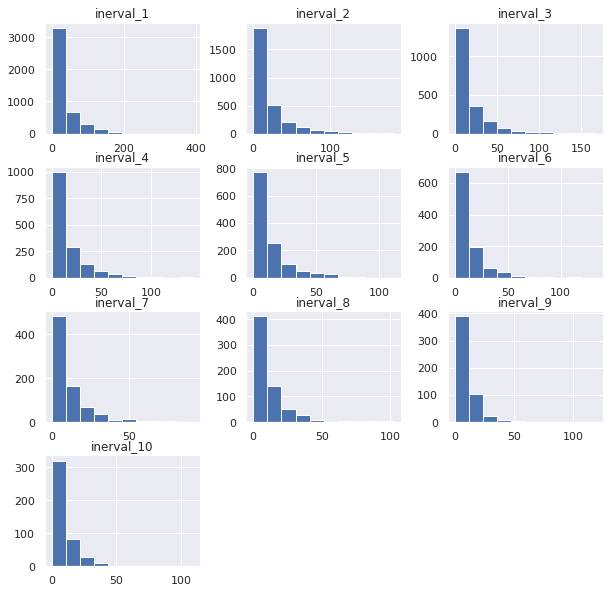

In [74]:
intrvl.iloc[:,1:11].hist() #since data is skewed, we'll use median instead of mean to gauge the average intervals between purchases

In [75]:
interval_median=np.nanmedian(intrvl.iloc[:,1:11],axis=0) 
#to ignore nan values when calculating median, we use nanmedian
#since 95% of users have 10 or under number of purchases, we cut the intrvl dataset
#the first column is always nan, so we can ignore it

In [76]:
interval_median

array([16., 12., 10.,  9.,  8.,  8.,  7.,  7.,  6.,  6.])

In [77]:
intrvl.iloc[:,1:11].columns #these are the intervals between purchases, interval_1 is the interval between first and second purchase

Index(['inerval_1', 'inerval_2', 'inerval_3', 'inerval_4', 'inerval_5',
       'inerval_6', 'inerval_7', 'inerval_8', 'inerval_9', 'inerval_10'],
      dtype='object')

In [78]:
intvl_plot=pd.DataFrame(data=interval_median,index=intrvl.iloc[:,1:11].columns,columns=['Median Interval in Days'])

## <a id='3.1'>Q3 Answer</a>

[List of Content](#sections)

<AxesSubplot:>

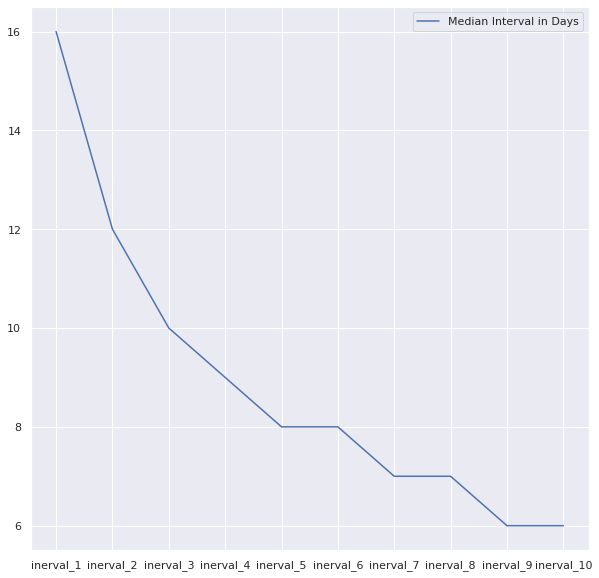

In [79]:
sns.lineplot(data=intvl_plot)

the reult above shows that as we go forward in intervals, median of the intervals decrease, so the more times someone buys the sooner they are going to come back and buy something else.

**Note that interval unit is day**

# Thank you for reading!

your feedback is much appreciated!